## REI602M Machine Learning - Homework 5
### Due: *Sunday* 21.2.2021

**Objectives**: The AdaBoost classifier. Visualization of high-dimensional data with PCA and t-SNE, Non-negative matrix factorizaton for topic extraction.

**Name**: (Alexander Guðmundsson), **email: ** (alg35@hi.is), **collaborators:** (if any)

Please provide your solutions by filling in the appropriate cells in this notebook, creating new cells as needed. Hand in your solution on Gradescope, taking care to locate the appropriate page numbers in the PDF document. Make sure that you are familiar with the course rules on collaboration (encouraged) and copying (very, very, bad).

Note: The Adaboost exercise involves more programming than usual.

### 1\. [Visualization of high-dimensional data, 20 points]
In this problem you will use PCA and t-SNE to visualize a high-dimensional data set derived from 300 Wikipedia articles selected from few broad groups of topics. For each Wikipedia article, the most common words such as 'an' and 'the' were removed and the rest of the words run through a stemming algorithm (converting e.g. 'longer' and 'longest' to 'long'). This resulted in a dictionary of all the words that occur in the 300 articles. The total number of words was 1000. A 1000-element histogram vector was then constructed for each article, where element $j$ is the frequency of word $j$ in the document, i.e. a 300 by 1000 matrix. The data is stored in the Numpy file `wikipedia_corpus.npz`.

a) [10 points] Use PCA to create a 2D figure where each article in the figure is represented by a short string based on its title.

b) [10 points] Use the t-SNE code provided with the assignment to create a similar figure to the one in a). You need to try a few different values of the perplexity parameter before you get a nice projection (include only the best one in your report). Can you "squeeze" more titles into this figure than the one in a)? 

What, if anything, can you conclude from your visualization experiments?

*Comments*:

1) The `wikipedia_corpus.npz` file contains three arrays which you access as follows

```python
import numpy as np
data=np.load('wikipedia_corpus.npz', allow_pickle=True)
dictionary = data["dictionary"]
article_titles = data["article_titles"]
article_histograms = data["article_histograms"] # Data matrix```

2) Creating informative figures usually takes some effort, so expect to spend some time tinkering with your figure. See http://www.cs.toronto.edu/~hinton/turian.png for an example of how your figure could look like.

3) You should try to use as large figure as possible, use `plt.figure(figsize=(xsize,ysize))`

4) You can only display titles of 100 -- 150 articles in the figure, otherwise you are likely to end up with a black mess.

5) Some of the titles are quite long and you should therefore truncate them somehow, e.g. by keeping only the two first words in the title. Useful Python's string `split` and `join` methods may come in handy. Use `plt.text` to display text in the figure.

6) Use PCA from scikit and the t-SNE code provided with this assignment (taken from https://lvdmaaten.github.io/tsne/). Note that for high-dimensional data, PCA is typically employed as a pre-processing step prior to running t-SNE in order to reduce the dimensionality of the data (typically to 30 - 50 dimensions). This reduces noise and speeds up the stochastic gradient descent in t-SNE. The preprocessing step is done automatically in the code supplied with the assignment but when you use the implementation in scikit-learn you must perform the PCA step manually.

7) While t-SNE is very useful, there are several caveats one should be aware of. See e.g.
https://distill.pub/2016/misread-tsne/

['000' '10' '100' '12' '14' '15' '16' '18' '19th' '20' '2000' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '20th' '24' '25' '30' '40' '50' 'ability' 'able' 'accepted' 'access'
 'according' 'act' 'action' 'active' 'activities' 'activity' 'added'
 'addition' 'additional' 'address' 'adopted' 'advance' 'affected' 'africa'
 'age' 'agencies' 'agency' 'agreement' 'agricultural' 'agriculture' 'aid'
 'air' 'aircraft' 'albedo' 'allow' 'allowed' 'allowing' 'allows'
 'altitude' 'america' 'american' 'amplitude' 'analog' 'analysis' 'anime'
 'announced' 'antenna' 'antennas' 'appear' 'appears' 'application'
 'applications' 'applied' 'approach' 'approximately' 'april' 'area'
 'areas' 'art' 'article' 'artist' 'artists' 'ash' 'asia' 'assembly'
 'assistance' 'associated' 'atlantic' 'atm' 'atmosphere' 'atmospheric'
 'attenuation' 'audio' 'august' 'australia' 'authority' 'available'
 'average' 'away' 'balance' 'ball' 'band' 'bandwidth' 'bank' 'base'
 'basic' 'basis' 'battle

Text(0.6, 0.5, 'Acid rain')

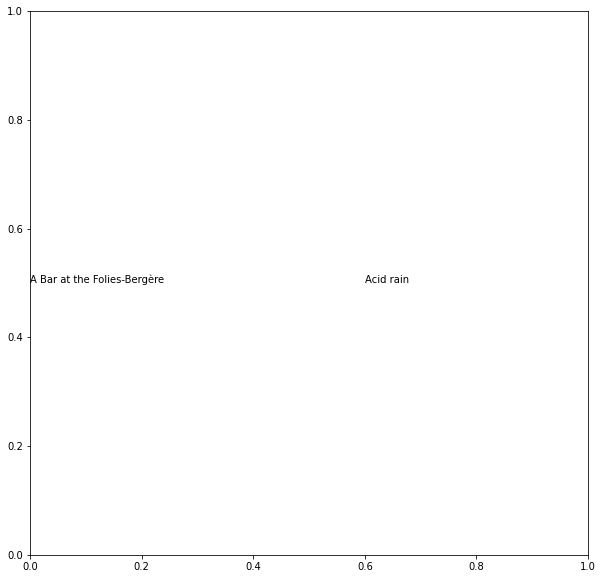

In [30]:
# a)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = np.load('wikipedia_corpus.npz', allow_pickle=True)
dictionary = data["dictionary"]
print(dictionary)
article_titles = data["article_titles"]
article_histograms = data["article_histograms"] #Data matrix

print(article_histograms)


#let's start by making the titles shorter
titlesDict = {}
for i in article_titles:
    arr = i.split(' ')
    word = ''
    for j in range(len(arr)):
        word = ' '.join(arr[0:j+1])
        if word not in titlesDict:
            titlesDict[word] = 1
            break
        

test = np.array(list(titlesDict.keys()))

print(article_histograms.shape)

print(test.shape)
print(article_titles.shape)
pca = PCA(n_components = 10).fit(article_histograms)

print(sum(pca.components_[0]))

plt.figure(figsize=(10,10))

plt.text(0,0.5,article_titles[0])
plt.text(0.6,0.5,article_titles[1])






      


In [ ]:
# b)
# Insert your code here
# ...

### 2\. [Topic discovery with NMF, 40 points]
Here you will use non-negative matrix factorization (NMF)to analyze the content of a collection of articles from the New York Times. In particular, you will attempt to discover the main topics of the article collection by performing non-negative matrix factorization to a term-document matrix derived from the raw articles.

The NMF approximates a *non-negative* $n \times p$ matrix $X$ of rank $r$ with a rank $k \leq r$ matrix such that

$$
X \approx WH
$$

where $W$ is a $n \times k$ matrix with $W_{ij} \geq 0$ and $H$ is a $k \times p$ matrix with $H_{ij} \geq 0$. Provided that $k$ is appropriately chosen, the *weight matrix* $W$ and *coefficient matrix* $H$ can reveal interesting structures in the data. Column $j$ of $X$ is approximated with (see comment 1 below)

$$
X_{:,j} \approx (WH)_{:,j} = H_{1j}W_{:,1} + H_{2j}W_{:,2} + \ldots + H_{kj}W_{:,k}
$$

where the subscript $:,j$ denotes column $j$. When the columns of $X$ correspond to individual articles, the columns of $W$ correspond to the main topics in the articles and column $j$ of $H$ contains information on how the topics are "mixed" together to form (approximately) column $j$ of $X$.

a) [30 points] Download the NYT articles from https://notendur.hi.is/steinng/kennsla/2021/ml/data/NYT.zip. Create a document-term matrix using word counts or TF-IDF (see below). For a given value of $k$, perform NMF on the *transposed* matrix and list the words corresponding to the largest $W_{ij}$ values for columns $j=1,\ldots,k$. You need to experiment with different values of $k$ to get interesting topic groupings. If $k$ is too low different topics will be mixed together, when $k$ gets large, the same subject will appear in multiple groups. Report your results (c.a. 20 words on each topic) for the value of $k$ that you end up picking.

b) [10 points] Select two or three topics that you find interesting. Identify the corresponding columns in $W$ and examine 3 - 5 articles using the largest $H$-values as indices. How does the content of the articles match the selected topics?

*Comments*:

1) The $n \times k$ matrix-vector product $y=Ax$ can be interpreted as a weighted sum of the columns of $A$,
$$
y=
\begin{array}{ccc}
~\mid &  & ~\mid \\
x_1 a_1 & + \ldots + & x_k a_k \\
~\mid & & ~\mid \\
\end{array}
$$
and matrix multiplication can be considered as multiple matrix-vector products.

2) Use the NMF implementation in`from sklearn.decomposition.NMF`. You can use the Wikipedia data set from problem 1) to test your NMF-based topic discovery code. Once you get convincing results, apply your code to the NYT data.

3) Use `sklearn.feature_extraction.text.CountVectorizer` to create the document-term matrix based on word counts from the raw newspaper articles. This function performs tokenization, counting, normalization and removes stop words. You can try the following parameter values `max_df=0.95` (remove words that occur in at least 95% of the documents), `min_df=10` (remove words that occur in fewer than ten documents), `stop_words='english'`. You should specify a value for `max_features=` (default is all).

4) Use `CountVectorizer.get_feature_names()` to get the list of words that were retained. Sidenote: Rare words are downplayed by the term-frequency encoding used here but they are often found to be informative. Therefore people often encode documents using term-frequency-inverse document frequency (`TfidfVectorizer` in Scikit-learn).

5) Scikit-learn's NMF function obtaines the factorization $X \approx WH$ by minimizing the objective function $0.5||X - WH||_F^2$ (where $||A||_F$ denotes the Frobenius norm of a $n \times p$ matrix $A$, $||A||_F = \sqrt{\sum_{i=1}^n \sum_{j=1}^p A_{ij}^2}$. The NMF implementation provides means to regularize the solution via parameters `alpha` and `l1_ratio`. You may want to experiment with these parameters to see if you can improve the list of topics.

6) The $H$ matrix is stored in `nmf.components_`

7) The NMF is described briefly in section 14.6 of ESL. A more detailed account can be found in the original article
http://www.cs.columbia.edu/~blei/fogm/2020F/readings/LeeSeung1999.pdf

In [264]:
# Read the NYT articles from a text file. Code adapted from a workbook found on Kaggle.
import numpy as np
import re

NYTFile = open('./NYT/nytimes_news_articles.txt', encoding='utf-8')
NYTFile.seek(0)
raw = NYTFile.readlines()
articles = []
sent = ''

for i in range(0, len(raw) - 1):
    if re.findall('URL',raw[i]) == []:
        sent = sent + raw[i]
        if (re.findall('URL', raw[i+1]) != []) and (i+1 < len(raw)):
            articles.append(sent.strip())
    else:
        sent = ''
print("Number of articles:", len(articles))

Number of articles: 8893


In [311]:
# a)
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer




max_words = 20  
    

#vectorize the data
vectorize = CountVectorizer(max_df=0.95, min_df=10, stop_words='english', max_features=5000)

X = vectorize.fit_transform(articles)
words = vectorize.get_feature_names() #words in the article

#Let's start by defining K = 10
k = 10
model = NMF(n_components = k, random_state=50, max_iter=5000) #creating the model
W = model.fit_transform(X)
print(W.shape)
H = model.components_
test = model.inverse_transform(W)


wordsByTopic = []
importanceIndex = [] # indexes of importance by topic
#get the top words from each topic
for i in range(k):
    importance_sorted = np.argsort(H[i])[:max_words]
    importanceIndex.append(importance_sorted)
    print("top 20 words in Topic " + str(i+1))
    wordsInTopic = [words[j] for j in importance_sorted]
    print(wordsInTopic)
    wordsByTopic.append(wordsInTopic)
    
    

    
    
    

    
    



(8893, 10)
top 20 words in Topic 1
['zuckerberg', 'kennedy', 'kenya', 'kerr', 'kerry', 'key', 'khan', 'kick', 'kelly', 'kid', 'kim', 'king', 'kingdom', 'kings', 'korea', 'kurdish', 'label', 'kids', 'kate', 'kasich']
top 20 words in Topic 2
['000', 'improve', 'improved', 'improvement', 'improving', 'inch', 'inches', 'incident', 'swept', 'sweet', 'income', 'incorrectly', 'increase', 'increased', 'increases', 'increasing', 'incredible', 'incredibly', 'independence', 'sweden']
top 20 words in Topic 3
['000', 'marathon', 'marc', 'maria', 'marijuana', 'marine', 'market', 'markets', 'married', 'martin', 'mary', 'maryland', 'massachusetts', 'match', 'matches', 'mateen', 'material', 'materials', 'math', 'matt']
top 20 words in Topic 4
['qualified', 'falluja', 'blamed', 'blasio', 'payment', 'blazers', 'bloc', 'reforms', 'blocked', 'shiite', 'yahoo', 'puck', 'madrid', 'majority', 'failing', 'refugees', 'board', 'courtroom', 'court', 'management']
top 20 words in Topic 5
['000', 'journalism', 'jou

as we can see from these topics, they are mostly arranged in an alphabetical order, all labels that are interesting could just be coinsident because of the alphabetical order.

In [307]:
Wtemp = importanceIndex[0]






[    0 13433 13434 13435 13436 13437 13438 13439 13440 13441 13442 13445
 13446 13447 13448 13432 13449 13451 13452 13455]
  (340, 0)	1
  (504, 0)	1
  (539, 0)	3
  (696, 0)	1
  (973, 0)	1
  (993, 0)	2
  (1107, 0)	1
  (1126, 0)	1
  (1459, 0)	1
  (1683, 0)	3
  (1927, 0)	6
  (1989, 0)	1
  (2277, 0)	1
  (2545, 0)	1
  (2566, 0)	1
  (2609, 0)	1
  (2753, 0)	1
  (2827, 0)	1
  (2834, 0)	1
  (2856, 0)	1
  (2975, 0)	1
  (3042, 0)	1
  (3172, 0)	1
  (3221, 0)	1
  (3834, 0)	1
  (4070, 0)	1
  (4699, 0)	1
  (4702, 0)	1
  (4945, 0)	1
  (5125, 0)	1
  (5153, 0)	1
  (5471, 0)	1
  (5616, 0)	1
  (6047, 0)	1
  (6502, 0)	1
  (6547, 0)	1
  (6655, 0)	2
  (6835, 0)	1
  (6840, 0)	1
  (7314, 0)	1
  (7811, 0)	1
  (7926, 0)	1
  (8608, 0)	1


In [ ]:
# b)
# Insert your code here
# ...

### 1\. [AdaBoost classifier, 40 points]

Implement the AdaBoost algorithm described on page 339 in ESL using decision tree stumps (root node + two leaf nodes) as base classifiers and redo the computations for the example of Figure 10.2 in ESL. Plot the training and test errors as a function of iteration number. Discuss briefly your findings. 

Repeat the experiments using a decision tree that captures 2-way feature interactions (3 leaf nodes). How do the results differ from the previous one?

Use the following artifical data set. The features $x_1^{(i)},\ldots,x_{10}^{(i)}$ are standard independent normally distributed variables and the output is defined as $y^{(i)}=1$ if $\sum_{j=1}^{10} (x^{(i)}_j)^2 > 9.34$ and zero otherwise (see comments below).

*Comments*:

1) Use `sklearn.tree.DecisionTreeClassifier` to generate the decision trees. Tree stumps are obtained by setting `max_leaf_nodes=2`. The behaviour of your ensemble classifier may be somewhat different from the one shown in Figure 10.2 in ESL since the implementation of the base tree classifier is different. For this reason you can use e.g. 1000 boosting iterations instead of 400.

2) The `DecisionTreeClassifier.fit` function accepts a vector of sample weights as an optional argument.

3) The training and test data is generated by the function `hw5_data` below. Use $n=1000$ samples for training and testing.

4) If $\text{err}_m$ becomes zero we are done.

In [99]:
import numpy as np
import math

def hw5_data(n=1000):
    # Toy dataset from page 339 in ESL
    X=np.random.randn(2*n,10)
    y=2*(np.sum(X**2,axis=1)>9.34)-1
    return X,y

In [272]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


X,y = hw5_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
n,m = X_train.shape
w = np.array([1/n]*len(X_train))

classifiers = []

for i in range(5):
    tree = DTC(max_leaf_nodes = 2).fit(X_train, y_train, sample_weight = w)
    for i in range(m):
        y_pred = tree.predict(X_train)
        #let's find Em
        error = 1 * (y_pred != y_train) #check if y_pred == y_test
        top = np.sum(np.dot(w,error))
        Em = (top/np.sum(w))
        if Em > 0.5:
            Em = 1 - Em
        #Let's find Am
        temp = (1-Em)/Em
        Am = np.log(temp)

        #let's find new weights
        for i in range(len(w)):
            exp = np.exp(Am*error[i])
            oldw = w[i]
            w[i] = oldw*exp


    print(Em)

0.5
0.49999999999997935
0.49999999999990796
0.49999999999995914
0.49999999999998457
